# Markov Chain Policy Evaluation: CI Coverage under Trajectory Dependence

This notebook repeats the coverage experiment in a more **RL-native** setting.

- Under a fixed policy π, the state process {S_t} forms a **Markov chain**.
- Rewards R_t are functions of states (and/or actions), hence inherit dependence.
- If we estimate the policy value using data from **one long trajectory**, the resulting samples are dependent, violating iid assumptions behind standard Wald CIs.

We compare empirical coverage of nominal 95% confidence intervals for:
1) **Independent episodes** (iid returns via resets)
2) **One long trajectory** (dependent returns via a Markov chain)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from pathlib import Path

RNG = np.random.default_rng(123)
ALPHA = 0.05  # 95% CI


In [2]:
project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent

figures_dir = project_root / "results" / "figures"
figures_dir.mkdir(parents=True, exist_ok=True)

print("Project root:", project_root)
print("Saving figures to:", figures_dir)


Project root: c:\Users\Ziqian Wang\Desktop\William\IMPERIAL\YEAR 2\cw_rl_ci
Saving figures to: c:\Users\Ziqian Wang\Desktop\William\IMPERIAL\YEAR 2\cw_rl_ci\results\figures


In [3]:
def naive_wald_ci(R: np.ndarray, alpha: float = 0.05) -> tuple[float, float]:
    """
    Naive Wald CI for mean under the IID assumption:
        mean ± z * s/sqrt(n)
    """
    n = len(R)
    m = float(np.mean(R))
    s = float(np.std(R, ddof=1))
    z = float(norm.ppf(1 - alpha / 2))
    half = z * s / np.sqrt(n)
    return m - half, m + half


In [4]:
def moving_block_bootstrap_ci(
    R: np.ndarray,
    block_len: int,
    B: int = 500,
    alpha: float = 0.05,
    rng: np.random.Generator | None = None,
) -> tuple[float, float]:
    """
    Moving Block Bootstrap percentile CI for the mean of a dependent sequence.

    - Resample contiguous blocks of length L
    - Stitch blocks to length n
    - Use bootstrap mean quantiles as CI
    """
    if rng is None:
        rng = np.random.default_rng(0)

    n = len(R)
    L = int(block_len)
    if L < 1 or L > n:
        raise ValueError("block_len must be between 1 and n.")

    starts = np.arange(0, n - L + 1)
    k = int(np.ceil(n / L))  # number of blocks to stitch

    boot_means = np.empty(B, dtype=float)

    for b in range(B):
        chosen = rng.choice(starts, size=k, replace=True)
        sample = np.concatenate([R[s:s+L] for s in chosen])[:n]
        boot_means[b] = sample.mean()

    lo = float(np.quantile(boot_means, alpha / 2))
    hi = float(np.quantile(boot_means, 1 - alpha / 2))
    return lo, hi


In [5]:
def simulate_markov_chain(T: int, P: np.ndarray, s0: int, rng: np.random.Generator) -> np.ndarray:
    """
    Simulate a Markov chain S_0,...,S_{T-1} with transition matrix P.

    P[i, j] = P(S_{t+1}=j | S_t=i)

    Returns
    -------
    states : array of shape (T,)
    """
    states = np.empty(T, dtype=int)
    states[0] = s0
    for t in range(1, T):
        states[t] = rng.choice([0, 1], p=P[states[t-1]])
    return states


def rewards_from_states(states: np.ndarray, r: np.ndarray, rng: np.random.Generator, noise_sigma: float = 0.0) -> np.ndarray:
    """
    Map states to rewards: R_t = r[S_t] + noise (optional).
    """
    base = r[states].astype(float)
    if noise_sigma > 0:
        base = base + rng.normal(0.0, noise_sigma, size=len(states))
    return base


In [6]:
# Transition matrix (choose moderately persistent chain to induce dependence)
# P[0->0]=0.95, P[0->1]=0.05
# P[1->0]=0.05, P[1->1]=0.95
P = np.array([[0.95, 0.05],
              [0.05, 0.95]])

# Reward function: r(0)=0, r(1)=1
r = np.array([0.0, 1.0])

# Optional reward noise (keep 0 for simplest)
NOISE_SIGMA = 0.0

# Approximate "true" stationary value E[R_t] by a long run
T_long = 500_000
states_long = simulate_markov_chain(T_long, P, s0=0, rng=RNG)
rewards_long = rewards_from_states(states_long, r, rng=RNG, noise_sigma=NOISE_SIGMA)

mu_true = float(np.mean(rewards_long))
print("Approx true mean reward (mu_true):", mu_true)


Approx true mean reward (mu_true): 0.5032


In [7]:
def sample_iid_episodes(n: int, burn_in: int, P: np.ndarray, r: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    """
    Generate approximately IID samples by resetting the chain each time.

    For each i:
      - start at s0=0
      - run burn-in steps
      - take the final reward as R_i

    With sufficient burn-in, R_i are approximately independent draws from (near) stationary distribution.
    """
    samples = np.empty(n, dtype=float)
    for i in range(n):
        states = simulate_markov_chain(burn_in + 1, P, s0=0, rng=rng)
        Rt = rewards_from_states(states[-1:], r, rng=rng, noise_sigma=NOISE_SIGMA)[0]
        samples[i] = Rt
    return samples


def sample_one_trajectory(n: int, P: np.ndarray, r: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    """
    Generate dependent samples from a single long trajectory:
      - simulate length n
      - return rewards R_0,...,R_{n-1}
    """
    states = simulate_markov_chain(n, P, s0=0, rng=rng)
    rewards = rewards_from_states(states, r, rng=rng, noise_sigma=NOISE_SIGMA)
    return rewards


In [8]:
def estimate_coverage(true_mu: float, sampler, n: int, M: int, ci_func, rng: np.random.Generator) -> float:
    hits = 0
    for _ in range(M):
        R = sampler(n=n, rng=rng)
        lo, hi = ci_func(R)
        hits += int(lo <= true_mu <= hi)
    return hits / M


In [9]:
NS = [20, 50, 100, 200, 500]

M_NAIVE = 2000
M_BLOCK = 300
BOOT_B = 500

burn_in = 50  # should be enough for this 2-state chain; can increase if needed

sampler_iid = lambda n, rng: sample_iid_episodes(n=n, burn_in=burn_in, P=P, r=r, rng=rng)
sampler_traj = lambda n, rng: sample_one_trajectory(n=n, P=P, r=r, rng=rng)

ci_naive = lambda R: naive_wald_ci(R, alpha=ALPHA)

def ci_block(R: np.ndarray) -> tuple[float, float]:
    n = len(R)
    L = max(5, int(round(2 * (n ** (1/3)))))  # heuristic
    return moving_block_bootstrap_ci(R, block_len=L, B=BOOT_B, alpha=ALPHA, rng=RNG)

cov_iid_naive = []
cov_traj_naive = []
cov_traj_block = []

for n in NS:
    c1 = estimate_coverage(mu_true, sampler_iid, n, M_NAIVE, ci_naive, RNG)
    c2 = estimate_coverage(mu_true, sampler_traj, n, M_NAIVE, ci_naive, RNG)
    c3 = estimate_coverage(mu_true, sampler_traj, n, M_BLOCK, ci_block, RNG)

    cov_iid_naive.append(c1)
    cov_traj_naive.append(c2)
    cov_traj_block.append(c3)

    print(f"n={n:4d} | iid-naive={c1:.3f} | traj-naive={c2:.3f} | traj-block={c3:.3f} (M_BLOCK={M_BLOCK})")


n=  20 | iid-naive=0.957 | traj-naive=0.311 | traj-block=0.363 (M_BLOCK=300)
n=  50 | iid-naive=0.940 | traj-naive=0.328 | traj-block=0.630 (M_BLOCK=300)
n= 100 | iid-naive=0.936 | traj-naive=0.336 | traj-block=0.670 (M_BLOCK=300)
n= 200 | iid-naive=0.945 | traj-naive=0.346 | traj-block=0.763 (M_BLOCK=300)
n= 500 | iid-naive=0.952 | traj-naive=0.340 | traj-block=0.810 (M_BLOCK=300)


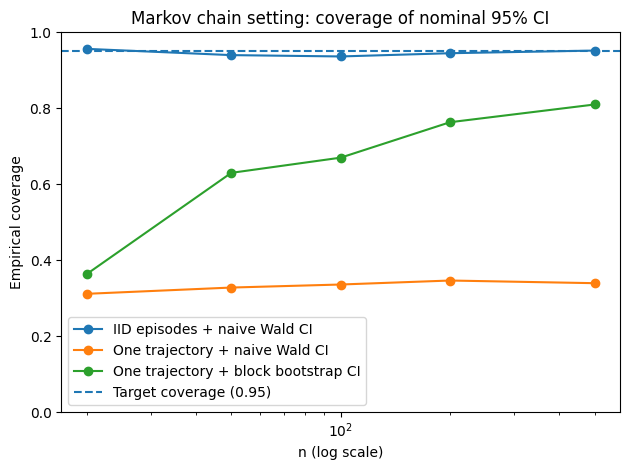

Saved figure to: c:\Users\Ziqian Wang\Desktop\William\IMPERIAL\YEAR 2\cw_rl_ci\results\figures\markov_chain_coverage.png


In [10]:
target = 1 - ALPHA

plt.figure()
plt.plot(NS, cov_iid_naive, marker="o", label="IID episodes + naive Wald CI")
plt.plot(NS, cov_traj_naive, marker="o", label="One trajectory + naive Wald CI")
plt.plot(NS, cov_traj_block, marker="o", label="One trajectory + block bootstrap CI")
plt.axhline(target, linestyle="--", label=f"Target coverage ({target:.2f})")

plt.xscale("log")
plt.ylim(0.0, 1.0)
plt.xlabel("n (log scale)")
plt.ylabel("Empirical coverage")
plt.title("Markov chain setting: coverage of nominal 95% CI")
plt.legend()
plt.tight_layout()

out_path = figures_dir / "markov_chain_coverage.png"
plt.savefig(out_path, dpi=200)
plt.show()

print("Saved figure to:", out_path)


In [11]:
def build_transition_matrix(p_stay: float) -> np.ndarray:
    """
    Symmetric 2-state Markov chain:
        P = [[p, 1-p],
             [1-p, p]]
    where p = P(S_{t+1}=S_t). Larger p => stronger dependence (slower mixing).
    """
    if not (0.5 < p_stay < 1.0):
        raise ValueError("Use p_stay in (0.5, 1.0) for meaningful persistence.")
    p = p_stay
    return np.array([[p, 1 - p],
                     [1 - p, p]])


def approximate_mu_true(P: np.ndarray, r: np.ndarray, rng: np.random.Generator, T_long: int = 300_000) -> float:
    """Approximate stationary mean reward by a long run simulation."""
    states = simulate_markov_chain(T_long, P, s0=0, rng=rng)
    rewards = rewards_from_states(states, r, rng=rng, noise_sigma=NOISE_SIGMA)
    return float(np.mean(rewards))


In [12]:
P_STAYS = [0.6, 0.8, 0.95, 0.98]
NS_SENS = [50, 100, 200, 500]

M_NAIVE = 2000
M_BLOCK = 300
BOOT_B = 500
burn_in = 100   # increase a bit for more persistent chains

ci_naive = lambda R: naive_wald_ci(R, alpha=ALPHA)

def ci_block(R: np.ndarray) -> tuple[float, float]:
    n = len(R)
    L = max(5, int(round(2 * (n ** (1/3)))))
    return moving_block_bootstrap_ci(R, block_len=L, B=BOOT_B, alpha=ALPHA, rng=RNG)

cov_traj_naive_by_p = {}
cov_traj_block_by_p = {}

for p_stay in P_STAYS:
    P_cur = build_transition_matrix(p_stay)
    mu_true_cur = approximate_mu_true(P_cur, r, RNG)

    sampler_iid_cur = lambda n, rng: sample_iid_episodes(n=n, burn_in=burn_in, P=P_cur, r=r, rng=rng)
    sampler_traj_cur = lambda n, rng: sample_one_trajectory(n=n, P=P_cur, r=r, rng=rng)

    # We mainly care about trajectory sampling; IID curve will stay near 0.95
    cov_naive_list = []
    cov_block_list = []

    for n in NS_SENS:
        c_naive = estimate_coverage(mu_true_cur, sampler_traj_cur, n, M_NAIVE, ci_naive, RNG)
        c_block = estimate_coverage(mu_true_cur, sampler_traj_cur, n, M_BLOCK, ci_block, RNG)
        cov_naive_list.append(c_naive)
        cov_block_list.append(c_block)

    cov_traj_naive_by_p[p_stay] = cov_naive_list
    cov_traj_block_by_p[p_stay] = cov_block_list

    print(f"p_stay={p_stay:.2f} | traj-naive={cov_naive_list} | traj-block={cov_block_list}")


p_stay=0.60 | traj-naive=[0.8715, 0.876, 0.8895, 0.89] | traj-block=[0.86, 0.89, 0.94, 0.9333333333333333]
p_stay=0.80 | traj-naive=[0.6835, 0.6835, 0.665, 0.6495] | traj-block=[0.8066666666666666, 0.9, 0.91, 0.9066666666666666]
p_stay=0.95 | traj-naive=[0.327, 0.341, 0.331, 0.334] | traj-block=[0.5566666666666666, 0.7166666666666667, 0.73, 0.8433333333333334]
p_stay=0.98 | traj-naive=[0.1875, 0.2225, 0.21, 0.192] | traj-block=[0.39, 0.44333333333333336, 0.5833333333333334, 0.66]


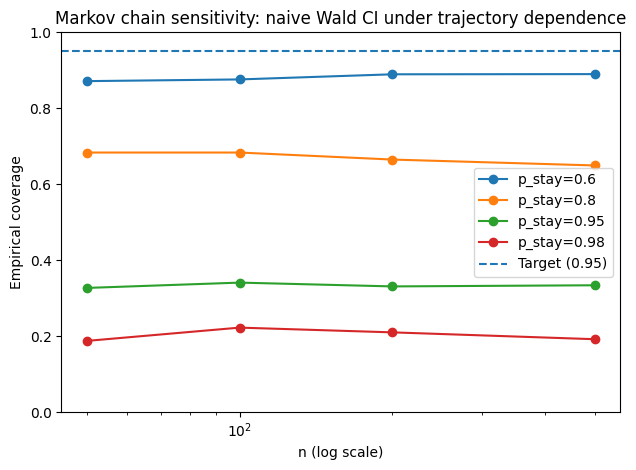

Saved: c:\Users\Ziqian Wang\Desktop\William\IMPERIAL\YEAR 2\cw_rl_ci\results\figures\markov_sensitivity_naive_by_pstay.png


In [13]:
target = 1 - ALPHA

plt.figure()
for p_stay in P_STAYS:
    plt.plot(NS_SENS, cov_traj_naive_by_p[p_stay], marker="o", label=f"p_stay={p_stay}")

plt.axhline(target, linestyle="--", label=f"Target ({target:.2f})")
plt.xscale("log")
plt.ylim(0.0, 1.0)
plt.xlabel("n (log scale)")
plt.ylabel("Empirical coverage")
plt.title("Markov chain sensitivity: naive Wald CI under trajectory dependence")
plt.legend()
plt.tight_layout()

out_path = figures_dir / "markov_sensitivity_naive_by_pstay.png"
plt.savefig(out_path, dpi=200)
plt.show()
print("Saved:", out_path)
